# Initialisation

In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive') 
os.chdir('/content/drive/My Drive/Colab Notebooks/P7_Réalisez des indexations automatiques d’images')

Mounted at /content/drive


In [2]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
import random
from PIL import Image, ImageOps
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import cluster, metrics
from sklearn.ensemble import RandomForestClassifier
import cv2
import timeit

from skimage.transform import resize
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16, decode_predictions
from keras.models import Model

# Constantes et fonctions

In [3]:
WIDTH = 224
HEIGHT = 224
STEP = 1000

# Chargement/nettoyage des images

1000 17.95s
2000 26.89s
3000 35.76s
4000 47.28s
5000 57.88s
6000 66.98s
7000 75.80s
8000 85.10s
9000 94.72s
10000 104.63s
11000 114.37s
12000 124.40s
13000 134.16s
14000 143.73s
15000 153.67s
16000 163.80s
17000 173.17s
18000 182.59s
19000 192.05s
20000 201.35s
20580 207.37s

Modes
RGB     20579
RGBA        1
dtype: int64

Fin (20580, 150528) 209.19s


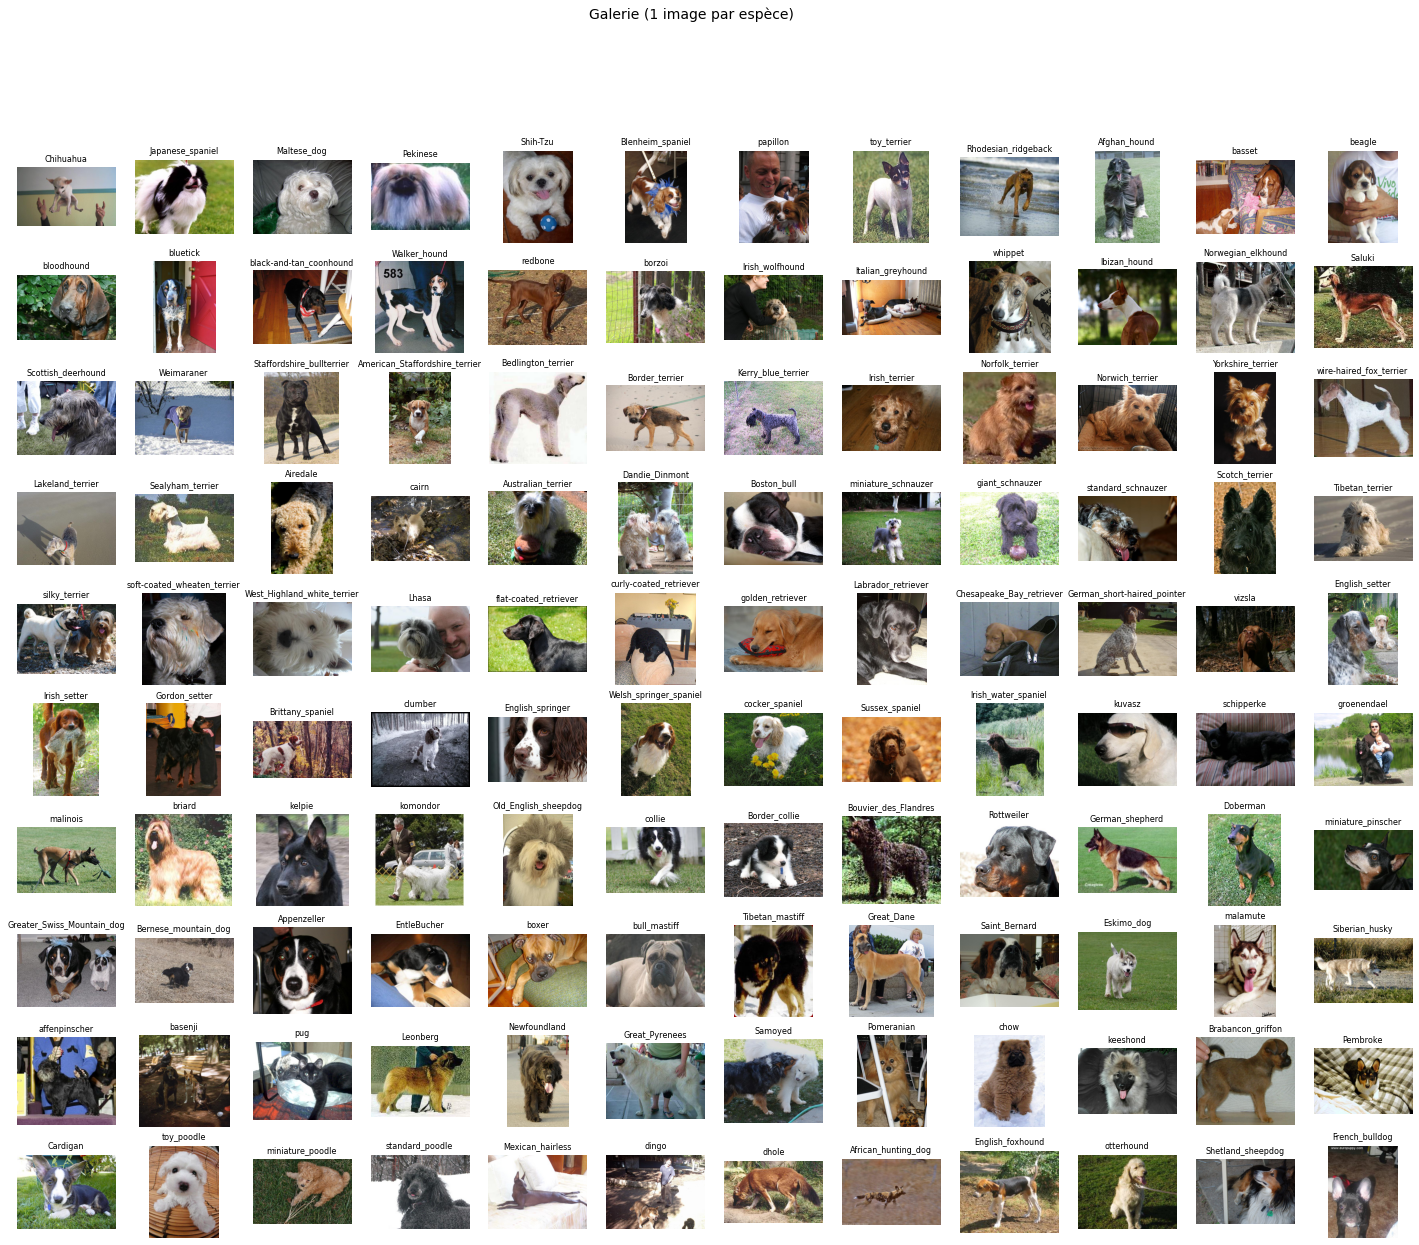

In [ ]:
breeds = [] 
dogs_img = [] 
dogs_img_gray = [] 
tailles = [] 
modes = [] 
temp = []
temp_gray = []
step = 0
nbreeds = 0

fig = plt.figure(figsize=(25, 20))
plt.suptitle('Galerie (1 image par espèce)', fontsize=14)

start_time = timeit.default_timer()

with tarfile.open('images.tar', 'r:tar') as tarFile:
    #tarInfo = tarFile.next()
    for d in tarFile.getmembers():
        if d.isfile():
            last_slash = d.name.rfind('/')
            breed = d.name[d.name.rfind('/', 1, last_slash)+1:last_slash]
            breed = breed[breed.find('-')+1:]
            #img_idx = d.name[last_slash+1:]

            file = tarFile.extractfile(d)
            img = Image.open(file)

            tailles.append(img.size)
            modes.append(img.mode)
            
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Dimensionnement des images 
            img_conv = img.resize((WIDTH, HEIGHT))

            # Correction de l'exposition
            img_conv = ImageOps.autocontrast(img_conv)

            # Correction du contraste
            img_conv = ImageOps.equalize(img_conv)
            #img = cv2.equalizeHist(img)

            # application d'un filtre médian
            img_conv = cv2.medianBlur(np.array(img_conv), 5)

            if breed not in breeds:
                nbreeds += 1 
                plt.subplot(10, 12, nbreeds)
                plt.title(breed, fontsize=8)
                plt.axis('off')
                plt.imshow(img)            

            dogs_img.append(img_conv.flatten())
            #dogs_img_gray.append(cv2.cvtColor(img_conv, cv2.COLOR_BGR2GRAY)\
            #                     .flatten())
            #temp.append([breed, img_conv])
            breeds.append(breed)
            #temp_gray.append([breed, cv2.cvtColor(img_conv, cv2.COLOR_BGR2GRAY)])

            step  = len(dogs_img) #dogs_df_new.shape[0]
            if step % STEP == 0:
                print("{} {:.2f}s".format(step, timeit.default_timer()-start_time))
                #break
                
if step % STEP != 0:
    print("{} {:.2f}s\n".format(step, timeit.default_timer()-start_time))

print('Modes\n{}\n'.format(pd.Series(modes).value_counts()))

dogs_img = np.array(dogs_img)
#dogs_img_gray = np.array(dogs_img_gray)
#dogs_df = pd.DataFrame(temp, columns=['img'])
print("Fin {} {:.2f}s".format(dogs_img.shape, timeit.default_timer()-start_time))

In [ ]:
with open('OC_DS_P7_dogs_img.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(dogs_img)
    pickler.dump(breeds)

In [4]:
with open('OC_DS_P7_dogs_img.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    dogs_img = unpickler.load() 
    breeds = unpickler.load()

FileNotFoundError: ignored

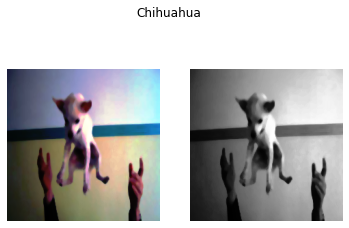

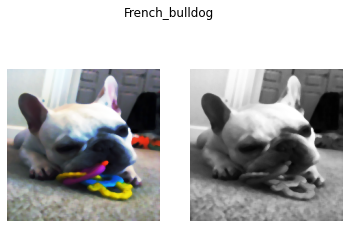

In [ ]:
#fig = plt.figure(figsize=(5, 3))
plt.suptitle(breeds[0])
plt.subplot(121)
plt.imshow(dogs_img[0].reshape(WIDTH, HEIGHT, 3))
plt.axis('off')
plt.subplot(122)
plt.imshow(dogs_img_gray[0].reshape(WIDTH, HEIGHT), cmap='gray')
plt.axis('off')
plt.show()
plt.suptitle(breeds[-1])
plt.subplot(121)
plt.imshow(dogs_img[-1].reshape(WIDTH, HEIGHT, 3))
plt.axis('off')
plt.subplot(122)
plt.imshow(dogs_img_gray[-1].reshape(WIDTH, HEIGHT), cmap='gray')
plt.axis('off')
plt.show()

# Exploration

## Tailles initiales des photos

Text(0, 0.5, 'height')

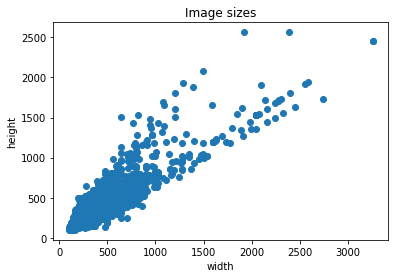

In [ ]:
shapes = np.asarray(tailles)
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
plt.ylabel("height")

## Distribution et étiquetage des espèces

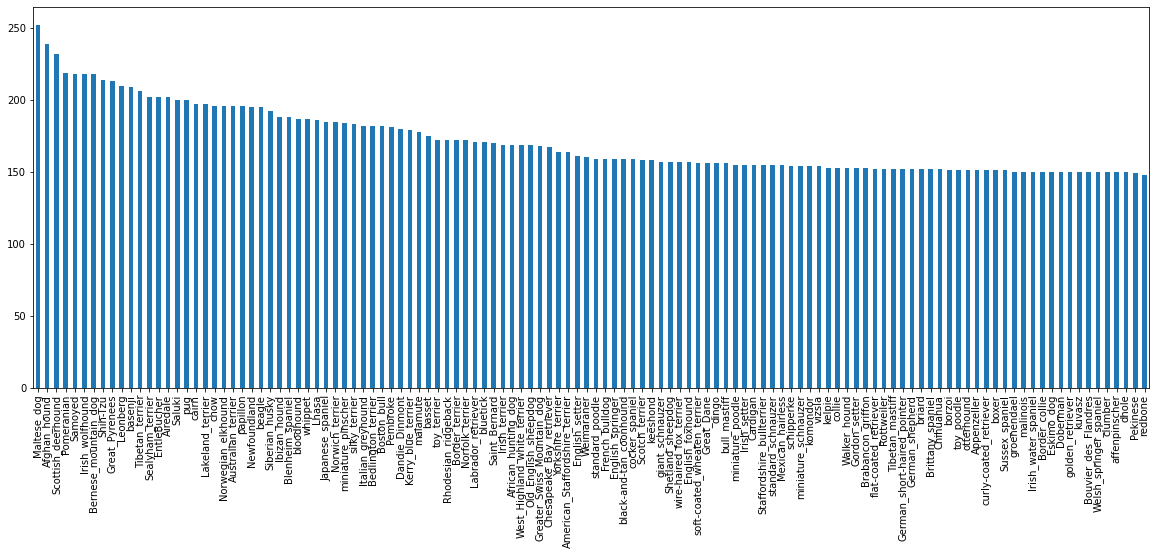

In [ ]:
fig = plt.figure(figsize=(20, 7))
pd.Series(breeds).value_counts().plot.bar()

breed_lbl = LabelEncoder() 
y = breed_lbl.fit_transform(breeds)

## Back-up dogs_df

In [ ]:
"""
with open('OC_DS_P7_dogs_df.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(dogs_df)
"""

In [ ]:
"""
with open('OC_DS_P7_dogs_df.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    dogs_df = unpickler.load()
"""

# Approches standards

## Conversion en noir et blanc

In [ ]:
NEW_SHAPE = 150 

dogs_img_gray = [cv2.resize(cv2.cvtColor(i.reshape(WIDTH, HEIGHT, 3), \
                                         cv2.COLOR_BGR2GRAY), \
                            (NEW_SHAPE, NEW_SHAPE)).flatten() \
                 for i in dogs_img]
dogs_img_gray = np.array(dogs_img_gray)
dogs_img_gray.shape

(20580, 22500)

### Echantillonnage à 50 individus / espèce

In [ ]:
dict_breeds = dict([])

for i in range(len(breeds)):
    try:
        dict_breeds[breeds[i]].append(i)
    except KeyError:
        dict_breeds[breeds[i]] = [i]

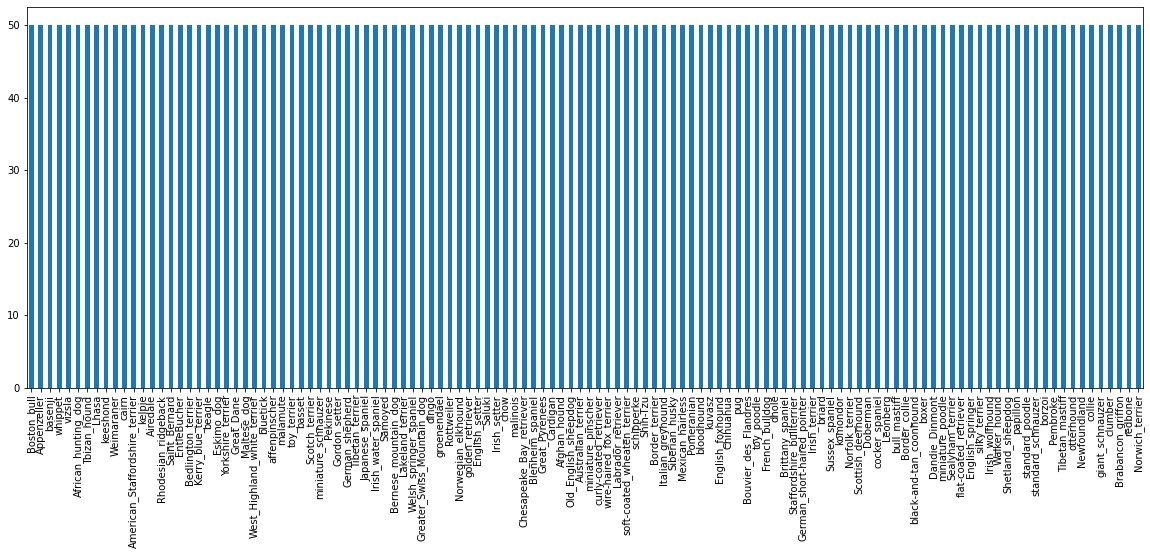

In [ ]:
dogs_img_sample = []
breeds_sample = []

SAMPLES = 50

for k in dict_breeds:
    temp = random.sample(dict_breeds[k], SAMPLES)
    dogs_img_sample.extend(dogs_img_gray[temp])
    breeds_sample.extend(np.array(breeds)[temp])

dogs_img_sample = np.array(dogs_img_sample)
breeds_sample = np.array(breeds_sample)

fig = plt.figure(figsize=(20, 7))
pd.Series(breeds_sample).value_counts().plot.bar()

In [ ]:
X = dogs_img_sample
X.shape, X.min(), X.max()

((6000, 22500), 0, 255)

In [ ]:
breed_lbl = LabelEncoder() 
y = breed_lbl.fit_transform(breeds_sample)
nb_clusters = len(set(y))
nb_clusters

120

In [ ]:
"""
X_sub, y_sub = zip(*random.sample(list(zip(dogs_img, breeds)), 5000))
X_sub = np.array(X_sub)
y_sub = np.array(y_sub)
X_sub.shape
"""

(5000, 150528)

In [ ]:
"""
X = dogs_img 

scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)
"""

### Réduction de dimension (PCA)

In [ ]:
argmax = []
cpt = 0 
VARIANCE = .95
STEP = 1000

X_scaled = X / 255

start_time = timeit.default_timer()

pca = PCA(VARIANCE)

pca.fit(X_scaled)

min_features = pca.n_components_
print('PCA min features {} en {:.2f}s'.format(min_features, timeit.default_timer()-start_time))

PCA min features 621 en 452.07s


Je fixe le nombre de composants à 1000


In [ ]:
start_time = timeit.default_timer()

pca = PCA(n_components=2000)
X_scaled_pca = pca.fit_transform(X_scaled)

print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

X_scaled_pca.shape

Durée 247.24s


(6000, 2000)

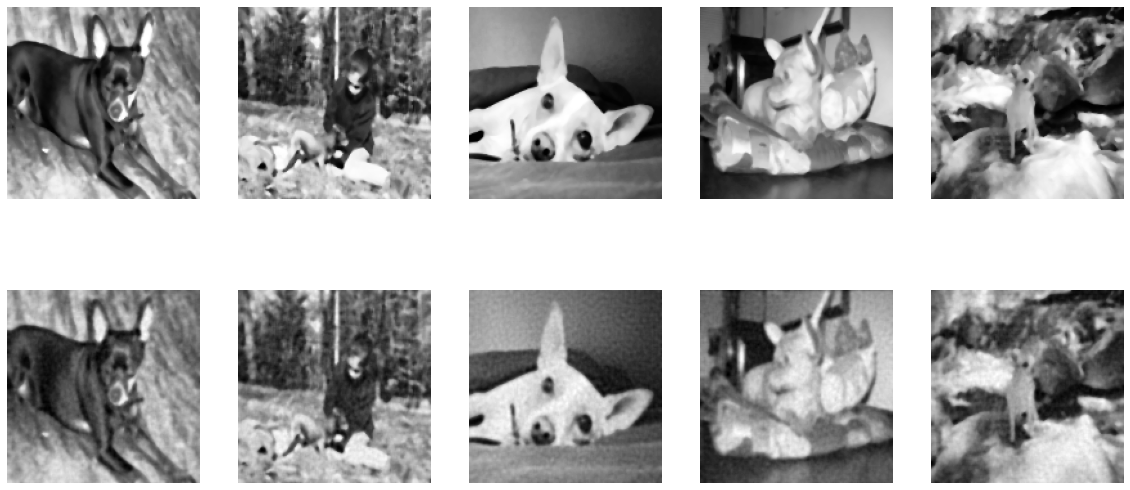

In [ ]:
num = 5 
cpt = 0

plt.figure(figsize=(20,20))

for cpt in range(num):

    plt.subplot(4, 5, 1 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow(X_scaled[cpt].reshape(150, 150), cmap='gray')

    plt.subplot(4, 5, 6 + cpt + num * (cpt // num))
    plt.axis('off')
    plt.imshow((pca.inverse_transform(X_scaled_pca[cpt])).reshape(150, 150), cmap='gray')

## Classifieur Forêts Aléatoires

In [ ]:
start_time = timeit.default_timer()

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.3, random_state=0)

#train model with randomforestclassifer
clf_rfc = RandomForestClassifier().fit(x_train, y_train)

# evaluate the model with test data
y_pred_rfc = clf_rfc.predict(x_test)
print(metrics.precision_score(y_test, y_pred_rfc, average='weighted'))
print(metrics.accuracy_score(y_test, y_pred_rfc))
print('Durée {:.2f}s'.format(timeit.default_timer()-start_time))

0.019729973260859297
0.01611111111111111
Durée 451.30s


## kMeans des features

### Feature detection

In [ ]:
STEP = 1000
features = []
l = []
w = []
cpt = 0 

orb = cv2.ORB_create(nfeatures=100)  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.

start_time = timeit.default_timer()

for i in dogs_img_sample: 
    
    key_points, descriptor = orb.detectAndCompute(i.reshape(NEW_SHAPE, NEW_SHAPE), None)
    #keypoints = orb.detect(img, None)
    #keypoints, descriptors = orb.compute(img, keypoints)

    l.append(descriptor.shape[0])
    w.append(descriptor.shape[1])

    #descriptor = descriptor.reshape(-1, 1)
    features.append(descriptor)
    
    cpt += 1
    if cpt % STEP == 0:
        print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

if cpt % STEP != 0:
    print("{} {:.2f}s".format(cpt, timeit.default_timer()-start_time))

1000 1.96s
2000 3.66s
3000 5.34s
4000 7.04s
5000 8.75s
6000 10.48s


In [ ]:
X_features = np.vstack(np.array(features, dtype='object')) / 255
print(X_features.shape)

(414650, 32)


In [ ]:
X_features.min(), X_features.max()

(0.0, 1.0)

### Clustering

In [ ]:
start_time = timeit.default_timer()

fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
inertia = []
cluster_range = range(5, 206, 20)
init_range = range(8, 19)

for i in init_range:
    myclust = cluster.KMeans(n_clusters=nb_clusters, random_state=1, init="k-means++", n_init=i).fit(X_features)
    #print('n_cluster {} {:.2f}s'.format(n, timeit.default_timer()-start_time))
    print('n_init {} {:.2f}s'.format(i, timeit.default_timer()-start_time))
    #silhouettes.append(metrics.silhouette_score(X_scaled_pca, myclust.labels_))
    inertia.append(np.sqrt(myclust.inertia_))

plt.plot(init_range, inertia, marker='o')

#best_cluster = cluster_range[np.argmax(silhouettes)]
#print('best clustering = ', best_cluster)

KeyboardInterrupt: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
start_time = timeit.default_timer()

# Using KMeans to compute centroids to build bag of visual words,n_clusters = 6, 
kmeans = cluster.KMeans(n_clusters=nb_clusters, random_state=0).fit(X_features)
print('Fin {:.2f}s'.format(timeit.default_timer()-start_time))

Fin 1541.70s


In [ ]:
start_time = timeit.default_timer()
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_features, kmeans.labels_))
print('Fin {:.2f}s'.format(timeit.default_timer()-start_time))

Silhouette Coefficient: 0.031


In [ ]:
# creating bag of visual words feature vectors for the images in the list
bovw_v = np.zeros([len(dogs_img_sample), 121])
for index, features in enumerate(dogs_img_sample):
  for i in kmeans.predict(features.reshape(-1,1)):
    bovw_v[index, i] +=1
    continue
  continue
  break

ValueError: ignored

In [ ]:
# starting training and prediction using bovw feature vectors & labels
x_train, x_test, y_train, y_test = train_test_split(bovw_v, y, test_size=0.2, random_state=0)

clf_svc = SVC().fit(x_train, y_train)

# evaluating model
y_pred_svc = clf_svc.predict(x_test)
print(accuracy_score(y_test, y_pred_svc))
# 0.28846153846153844
print(precision_score(y_test, y_pred_svc, average='weighted', labels=np.unique(y_pred_svc)))
# 0.30264320348454965

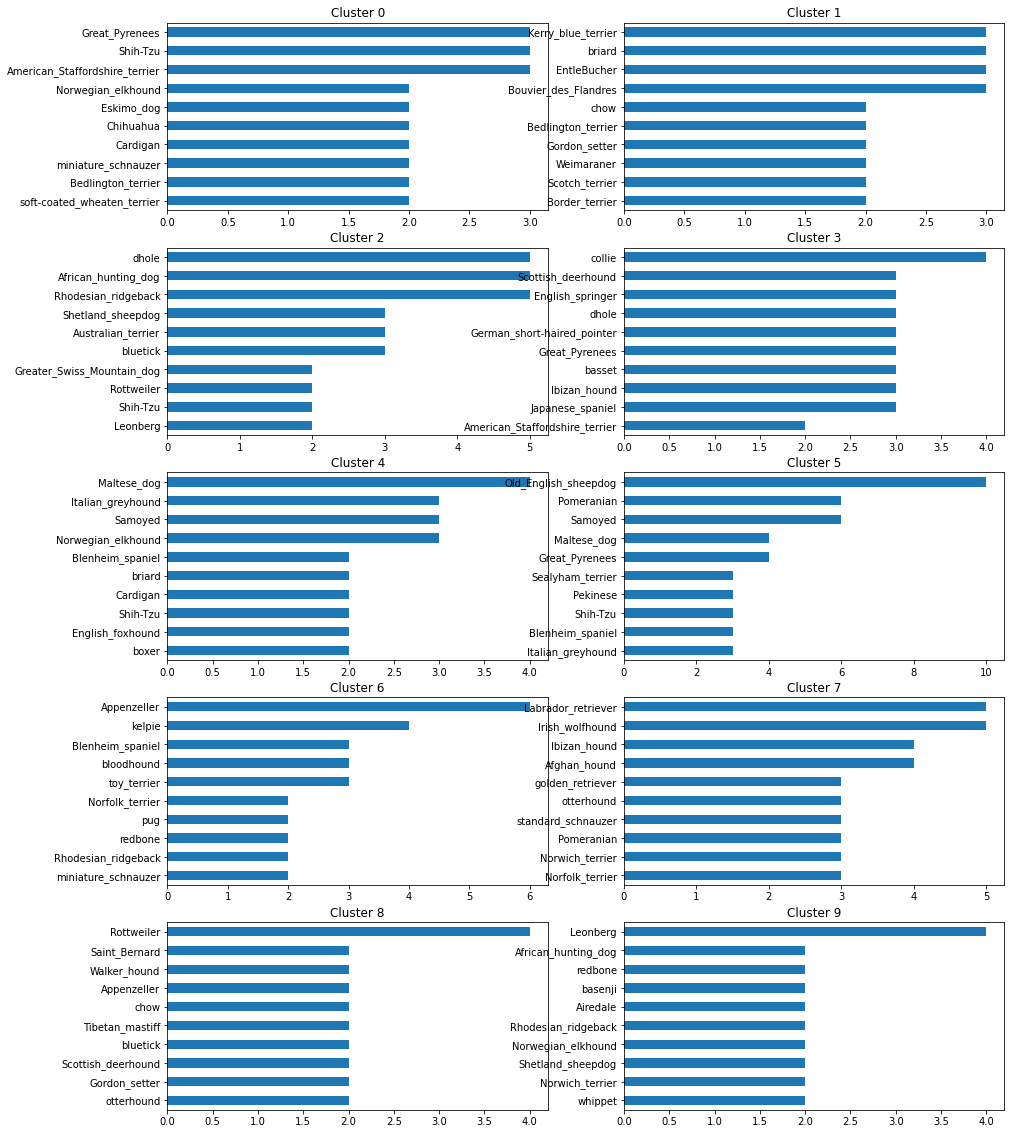

In [ ]:
fig = plt.figure(figsize=(15, 20))

for c in range(10):
    plt.subplot(5, 2, c+1)
    plt.title('Cluster {}'.format(c))
    gray_samples[gray_samples.cluster == c].breed.value_counts(ascending=True)[-10:].plot.barh()

NameError: ignored

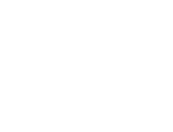

In [ ]:
#Visualisation for clusters = clust
plt.figure(figsize=(20,10))
clust = 2 #enter label number to visualise
num = 20 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(4, 6, i) #(Number of rows, Number of column per row, item number)
    plt.axis('off')
    plt.imshow(X_scaled[cluster_index[clust][i]].reshape(150, 150) * 255, cmap='gray')
    
#plt.show()

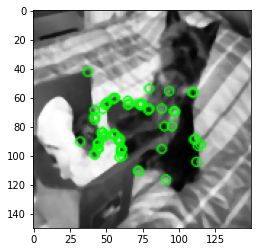

In [ ]:
kp_img = cv2.drawKeypoints(gray_samples.img.iloc[-1], key_points, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
plt.imshow(kp_img)

In [ ]:
with open('OC_DS_P7_X_scaled_pca.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL)
    pickler.dump(X_scaled_pca)

# CNN

## Séparation train/test

In [5]:
with open('OC_DS_P7_dogs_df.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    dogs_df = unpickler.load()

In [ ]:
type(np.expand_dims(dogs_df.img[0].reshape(224, 224, 3), axis=0))

numpy.ndarray

In [ ]:
dogs_df.head()

,breed,img,breed_lbl
0,Chihuahua,"[[[27, 29, 62], [27, 29, 62], [28, 30, 62], [2...",17
1,Chihuahua,"[[[48, 47, 41], [48, 46, 39], [43, 41, 35], [3...",17
2,Chihuahua,"[[[242, 242, 241], [242, 242, 242], [241, 242,...",17
3,Chihuahua,"[[[191, 179, 189], [183, 172, 181], [115, 121,...",17
4,Chihuahua,"[[[104, 107, 245], [99, 114, 193], [89, 114, 1...",17


In [ ]:
breed_lbl = LabelEncoder() 
y = breed_lbl.fit_transform(dog_df.breed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape

((14406, 150528), (6174, 150528))

In [6]:
base_model = VGG16()

553467904/553467096 [==============================] - 3s 0us/step


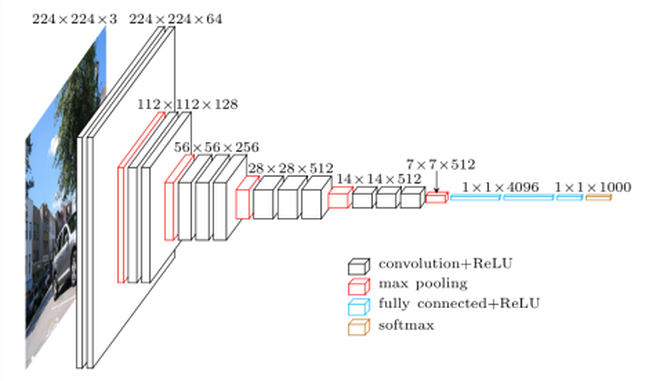

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Base line

In [ ]:
temp = np.random.choice(dogs_img, 6, replace=False) 
fig = plt.figure(figsize=(20, 12))
cpt = 0 

for i, v in temp.iterrows(): 
    cpt += 2 

    img = v.img
    img_vgg = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img_vgg = preprocess_input(img_vgg)  # Prétraiter l'image comme le veut VGG-16

    y = base_model.predict(img_vgg)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
    pred = decode_predictions(y, top=3)[0]

    plt.subplot(4, 6, cpt + 6 * np.floor(cpt/7))
    plt.axis('off')
    plt.title(v.breed)
    plt.imshow(img)

    plt.subplot(4, 6, cpt + 6 * (1 + np.floor(cpt/7)))
    plt.barh([w[1] for w in pred], [w[2] for w in pred], height=.1)
    # Afficher les 3 classes les plus probables
    #print('Top 3 :', decode_predictions(y, top=3)[0])

ValueError: ignored

## Transfer learning

J'entraine seulement les couches les plus hautes (fine-tunning partiel)

In [8]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [21]:
breed_lbl = LabelEncoder() 
y = breed_lbl.fit_transform(dogs_df.breed)

onehot = OneHotEncoder()
y = onehot.fit_transform(np.expand_dims(y, axis=1)).toarray()

In [43]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

y = LabelEncoder().fit_transform(dogs_df.breed)
onehot = OneHotEncoder()
y = onehot.fit_transform(np.expand_dims(y, axis=1)).toarray()

#Generator
def generator(df):
    while 1:
        for i, v in dogs_df.iterrows():
            x = v['img'].reshape(224, 224, 3)
            #x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            y = df.iloc[i]['breed_lbl']
            print(y)
            y = onehot.transform(y).toarray()
            print('4')
            #print(img.shape,np.array([y]).shape)
            yield (x, y)
                    
gen = generator(dogs_df)

In [42]:
y

17

In [41]:
y = dogs_df.iloc[0]['breed_lbl']
onehot.transform(y).toarray()

ValueError: ignored

In [38]:
X_pred = model.predict(gen, steps=20580, verbose=1)

17


ValueError: ignored